## Deep reinforcement learning

### Summary and setup

This session is designed to be run on GitHub codespaces. Please refer to the documentation at [TBC] to get started. 

### Questions

- How can an agent learn when state-action spaces do not suit a tabular value function format, for example due to continuous variables?
- What are the strengths and weaknesses of using artificial neural networks for Q-learning?

### Objectives

- Understand how to implement an artificial neural network-based approach to Q-learning using the PyTorch deep learning library
- Learn why this method can produce unstable results and how to manage this

### Prerequisites

- Session 1: Reinforement learning with tabular value functions


### 1. Introduction

In the previous session, we trained an agent to navigate some simple environments with limited state-action spaces: the agent could be located in one of a relatively small number of squares on a grid and was able to move either up, down, left or right. This time, although our agent will have just three possible actions to choose from, it faces a trickier challenge because the observation space is much larger, comprising of continuous - rather than discrete - values. 

Fortunately, there is a powerful tool to help with this task: artificial neural networks. Neural networks can be trained to approximate any function, including an agent's value function, with a degree of accuracy dictated by the number of neurons in the network and the amount of time spent on training the network. 

Function approximation of this kind allows us to work in continuous state spaces by enabling generalisation between similar states, and can therefore be applied to much larger problems than tabular reinforcement learning can. 

In this session, we will be investigating how these concepts can help us to train an agent in the "Acrobot" environment, which is described in detail in the [documentation on the gymnasium library's website](https://gymnasium.farama.org/environments/classic_control/acrobot/):

> The system consists of two links connected linearly to form a chain, with one end of the chain fixed. The joint between the two links is actuated. The goal is to apply torques on the actuated joint to swing the free end of the linear chain above a given height while starting from the initial state of hanging downwards.

The available actions are applying torque of -1, 0 or 1 to the actuated joint. 

<img src="img/acrobot.gif" />

We will be using Q-learning, an off-policy approach to reinforcement learning, for this task. However we must be wary that we are dealing with all three components of what [Sutton and Barto (2015)](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf) refer to as the "deadly triad" that can lead to instability in our model's outputs:

- function approximation
- bootstrapping, i.e. using estimates of future rewards rather than relying on actual rewards
- off-policy training

By the end of this session, we will have explored some ways to overcome these stability problems. 

In [1]:
import gymnasium as gym

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn.objects as so
import math
import random
from collections import namedtuple, deque
 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

%matplotlib widget

### Network construction

We begin by creating a Python class that inherits from PyTorch's base class for neural network modules. For the purposes of this demonstration, we use a simple feed-forward network with two hidden layers.

In [23]:
class QNetwork(nn.Module):
    """Represent the agent's policy model"""
    
    def __init__(self, state_size, action_size, layer1_size=64, layer2_size=64):
        """Build a network that can take a description of an environment's state and 
        output the value of available actions.
        
        Params
        =======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            layer1_size (int): Number of nodes in first hidden layer
            layer2_size (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__() ## calls __init__ method of nn.Module class
        self.layer1 = nn.Linear(state_size, layer1_size)
        self.layer2 = nn.Linear(layer1_size, layer2_size)
        self.layer3 = nn.Linear(layer2_size, action_size)

    def forward(self, x):
        """Map state -> action values."""
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In general, computation with PyTorch will run faster on GPUs that support CUDA, but PyTorch code is often written such that it will also run (more slowly) on CPUs. To this end, it is common practice to keep track of which category of device the code is running on:

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Memory

In the conventional application of a neural network to a supervised machine-learning problem, we assume that each sample in the training dataset is independent of all the others, e.g. for an image classification task the correct classification of image A does not depend on the algorithm's performance when faced with image B. 

However, this is not the case in our reinforcement learning challenge, where we are trying to learn the value of a state-action pair, but this value depends on the actions that the agent will take at subsequent time steps. Changing the value function changes the agent's policy, which changes the value function and so on, meaning that the value of a state-action pair will shift throughout training. 

In other words, samples in the training data are temporally correlated and are not drawn from a stationary distribution. One method to alleviate this difficulty is encoded below. We will give our agent a "memory" to store its experiences in, then randomly sample from the experiences in this memory to create mini-batches of training data that are not temporally correlated with one another.

We create a bespoke buffer class to perform this function, making use of a couple of helpers from Python's `collections` module: `deque`, which is similar to a `list` but can be set to have a maximum length - in our case the `buffer_size` - and `namedtuple`, which makes `tuple`s more readable by enabling access to their data as named fields (rather than just by a numeric index). 

In [25]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples"""
    
    def __init__(self, action_size, buffer_size, batch_size):
        """Initialize a ReplayBuffer object

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state",
                                                                "action",
                                                                "reward",
                                                                "next_state",
                                                                "done"])

    def add(self,state, action, reward, next_state,done):
        """Add a new experience to memory"""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory"""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory"""
        return len(self.memory)

#### Delayed updates
A second cause of instability in our approach arises from correlations between the current value for a state-action pair $ Q(s_t, a_t) $ and the target at each time step $ r_t + γ\max_a\> Q(s_{t+1}, a) $, especially when $ s_t $ and $ s_{t+1} $ are similar. 

To handle this problem, we will provide our agent with two artificial neural networks, $ Q $ and $ Q_{target} $, using the value of $ Q $ to determine which action to take at each time step and $ Q_{target} $ to define the target in our update function: 

$$ Q(s_t, a_t) = Q(s_t, a_t) + α(r_t + γ\max_a\> Q_{target}(s_{t+1}, a) - Q(s_t, a_t)) $$

The weights of $ Q_{target} $ will periodically be updated to align with those of $ Q $; what this means in practice will be defined in the code below.

### Configuration

We can dictate how the agent learns from its environment with the following parameters. The discount factor and learning rate parameters are familiar from the previous session, and the meaning of the buffer and batch size parameters should be clear from the `ReplayBuffer` definition above. The value of `UPDATE_EVERY` relates to the periodic updating of the weights of $ Q_{target} $ (mentioned above).

In [26]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate
UPDATE_EVERY = 8        # how often to update the target network

### Agent

We are now in a position to create a deep Q network (DQN) agent, which will contain two instances of the `QNetwork` class and a `ReplayBuffer` memory. 

We use PyTorch's implementation of the [Adam algorithm](https://arxiv.org/abs/1412.6980) to optimise the parameters in our $ Q $ network, but note that no such optimisation is needed for the $ Q_{target} $ network, whose parameters will be copied directly from the pre-optimised parameters in $ Q $.

In [27]:
class DQN_agent():
    """Agent that interacts with and learns from an environment using artificial neural networks 
    to approximate its state-action value function"""

    def __init__(self, env, state_size, action_size):
        """Initialize an Agent object

        Params
        =======
            env: an environment object
            state_size (int): dimension of each state
            action_size (int): dimension of each action
        """

        self.env = env
        self.state_size = state_size
        self.action_size = action_size
        self.frames = [] # To visualise the learned behaviour of the agent
       
        # Function approximation networks:
        self.q_network = QNetwork(state_size, action_size).to(device)
        self.q_network_target = QNetwork(state_size, action_size).to(device)

        # Optimise the parameters in the Q network, using the learning rate defined above
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

We give the agent a method for reducing its rate of exploration of the environment over time - the theory being that the more the agent learns about its environment the less useful it will be to take a random action - i.e. the emphasis shifts from exploration of unknown state-action pairs to exploitation of learned knowledge. 

In [28]:
def get_explore_rate(self, episode, decay):
    """Calculates the logarithmically decreasing explore rate

    Params
    ======
        episode (int): the current episode
        decay (float): controls the rate of decay of the explore rate
    
    Returns
    =======
        explore_rate (float): the epsilon in the agent's epsilon-greedy policy
    """

    # Input validation
    if not 0 < decay:
        raise ValueError("decay needs to be above 0")
    
    # Ensure rate returned is between 0 and 1:
    min_explore_rate = 0
    max_explore_rate = 1
    explore_rate = 1.0 - math.log10(episode / decay)
    return max(min_explore_rate, min(max_explore_rate, explore_rate))

DQN_agent.get_explore_rate = get_explore_rate

As with the agent that learned the tabular value function in the previous session, here we also use the concept of an epsilon-greedy policy - slightly modified to incorporate the behaviour of the agent's neural networks. First we predict the values for each action in the current state using the Q network. Then with probability `1 - epsilon` we return the action with the highest value and with probability `epsilon` we return a random action. 

In [29]:
def epsilon_greedy_policy(self, state, epsilon=0):
    """Returns action for given state as per current policy

    Params
    ======
        state (array_like): current state
        epsilon (float): for epsilon-greedy action selection
    """

    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    self.q_network.eval()
    with torch.no_grad():
        action_values = self.q_network(state)
    self.q_network.train()

    # Epsilon-greedy action selction
    if random.random() > epsilon:
        return np.argmax(action_values.cpu().data.numpy())
    else:
        return random.choice(np.arange(self.action_size))

DQN_agent.policy = epsilon_greedy_policy

The function to update $ Q_{target} $  is as follows, with network weights from the $ Q $ network copied directly across:

In [30]:
def update_target(self, model, target_model):
    """Update target model parameters

    Params
    =======
        local model (PyTorch model): weights will be copied from
        target model (PyTorch model): weights will be copied to
    """
    for target_param, local_param in zip(target_model.parameters(), model.parameters()):
        target_param.data.copy_(local_param.data)
  
DQN_agent.update_target = update_target    

Now we can write the `update_Q` function to train our Q network. This function takes a sample of `experiences` from the agent's memory as input and uses the discount factor, `GAMMA`, defined in the parameters section above. 

First we use the target network to predict the expected discounted future return from each of the `next_states` in the sample of experiences. 

Then we construct the Q-learning targets using these future predictions, the observed reward and `GAMMA`, just like in the tabular methods. 

Next we train the Q network using the loss between these targets and the predicted targets given by the current Q network weights. Finally we do our target network update.

In [31]:
def update_Q(self, experiences):
    """Update value parameters using given batch of experience tuples.
    
    Params
    =======
        experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
    """
    states, actions, rewards, next_states, dones = experiences
    
    # We use mean squared error as the loss function
    criterion = torch.nn.MSELoss()
    # The local model is the one we need to train so we put it in training mode
    self.q_network.train()
    # Conversely, we want the target model to be in evaluation mode so that when 
    # we do a forward pass it does not calculate the gradients
    self.q_network_target.eval()
    
    with torch.no_grad():
        future_pred = self.q_network_target(next_states).detach().max(1)[0].unsqueeze(1)

    # .detach() ->  Returns a new Tensor, detached from the current graph.
    targets = rewards + (GAMMA * future_pred * (1 - dones))

    # Shape of output from the model (batch_size, action_size) 
    predicted_targets = self.q_network(states).gather(1, actions)

    loss = criterion(predicted_targets, targets).to(device)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

DQN_agent.update_Q = update_Q

Then we have our training function. This is very similar to the tabular case, the main difference is we need to add to and sample from the agent's memory. 

In [32]:
def train(self, n_episodes=200, max_t=1000, decay=None, verbose=True):
    """Deep Q-Learning
    
    Params
    ======
        n_episodes (int): maximum number of training epsiodes
        max_t (int): maximum number of timesteps per episode
        decay (float): controls the rate of decay of the explore rate
        verbose (bool): whether to print updates on the training process
    
    Returns
    =======
        returns (list[float]): episode returns for analysis of training performance
    """
    returns = [] # list containing total reward from each episode

    # Reasonable default value for explore_rate decay:
    if not decay:
        decay = n_episodes / 11

    for episode in range(1, n_episodes+1):
        explore_rate = self.get_explore_rate(episode, decay)
        state, prob = self.env.reset()
        episode_return = 0

        # For visualising the behaviour in the final episode:
        if episode == n_episodes:
            self.frames.append(self.env.render())

        for t in range(max_t): 
            action = self.policy(state, explore_rate)
            next_state, reward, done, info, prob = self.env.step(action)

            # For visualisation:
            if episode == n_episodes:
                self.frames.append(self.env.render())

            self.memory.add(state, action, reward, next_state, done)
            # If enough samples are available in memory, get random subset and learn:
            if len(self.memory) > BATCH_SIZE:
                experience = self.memory.sample()
                self.update_Q(experience)
                # Update target network every UPDATE_EVERY time steps:
                if t % UPDATE_EVERY == 0:
                    self.update_target(self.q_network, self.q_network_target)
            state = next_state
            episode_return += reward
            if done:
                break
    
        returns.append(episode_return)
        # If verbose mode is switched on, log returns every 10 episodes:
        if verbose and episode % 10 == 0:
          print(f'Episode {episode}\tExplore rate {explore_rate:.2f}\tReturn {episode_return:.2f}')
    
    return returns

DQN_agent.train = train

Finally we're going to give our agent a helper function to understand what it learned about the environment:

In [33]:
def visualise(self):
    """Convert the agent's behaviour in the final episode into a matplotlib animation"""
    fig, ax = plt.subplots(figsize=(5, 4))
    plt.axis('off')
    plt.suptitle('Learned policy')
    output_frames = [[ax.imshow(frame, animated=True)] for frame in self.frames.copy()]
    return animation.ArtistAnimation(fig, output_frames, interval=50, blit=True, repeat=False)

DQN_agent.visualise = visualise

#### Algorithm specification

The code above is an implementation of this algorithm, adapted from [Mnih et al, 2015](https://www.nature.com/articles/nature14236):

- Initialize replay memory $D$ to capacity $N$
- Initialize action-value function $Q$ with random weights $θ$
- Initialize target action-value function $Q_{target}$ with random weights $θ^-$
- **For** $episode=1,M$ **do**:
    - Initialize environment and observe state $s_1$
    - **For** $t = 1,T$ **do**:
        - With probability $ε$ select a random action $a_t$
        - otherwise select $a_t = \max_a\> Q(s_t,a;θ)$
        - Execute action $a_t$ and observe reward $r_t$ and state $s_{t+1}$
        - Store transition $(s_t, a_t, r_t, s_{t+1})$ in $D$
        - Set $s_{t+1} = s_t$
        - Sample random minibatch of transitions $(s_j, a_j, r_j, s_{j+1})$ from $D$
        - Set $y_j = r_j$ if episode terminates at step $j+1$
        - otherwise set $y_j = r_j + γ\max_{a'}\> Q_{target}(s_{j+1},a';θ^-)$
        - Perform a gradient descent step on $(y_j-Q(s_j,a_j;θ))^2$ with respect to network parameters $θ$
        - Every $C$ steps reset $Q_{target} = Q$
    - **End For**
- **End For**

#### Assignment questions

1. Where in the code do we select a random action with probability $ε$?
2. Which variable in the code determines the size of the minibatches selected for analysis in `ReplayBuffer` $D$?
3. Where in the code do we perform the gradient descent step?

#### Solutions

1. Line 20 of the `epsilon_greedy_policy` method returns `random.choice(np.arange(self.action_size))` with probability $ε$.
2. It's the `BATCH_SIZE` parameter, which is set as a global variable in this notebook.
3. The final line of the `update_Q` method is the one that updates the parameters of the $Q$ network using gradient descent.

### Putting it all together

Having laid all the groundwork, training the model on a newly constructed environment is straightforward:

In [13]:
env = gym.make('Acrobot-v1', render_mode='rgb_array')
agent = DQN_agent(env, state_size=6, action_size=3)
returns = agent.train(n_episodes=100)

Episode 10	Explore rate 0.96	Return -538.00
Episode 20	Explore rate 0.66	Return -246.00
Episode 30	Explore rate 0.48	Return -149.00
Episode 40	Explore rate 0.36	Return -127.00
Episode 50	Explore rate 0.26	Return -113.00
Episode 60	Explore rate 0.18	Return -100.00
Episode 70	Explore rate 0.11	Return -95.00
Episode 80	Explore rate 0.06	Return -298.00
Episode 90	Explore rate 0.00	Return -132.00


<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


Episode 100	Explore rate 0.00	Return -98.00


We can visualise how rapidly the agent learned from its environment:

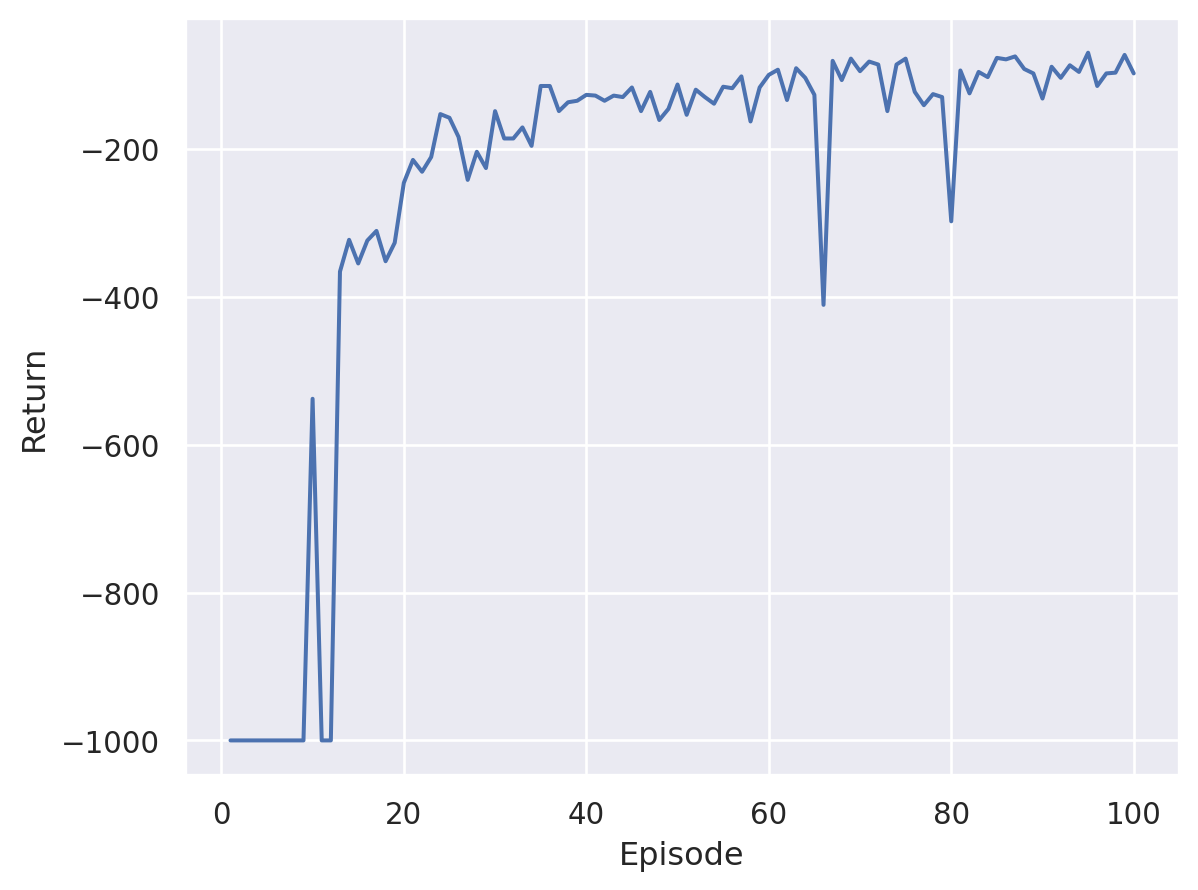

In [14]:
(
    so.Plot(
        data=pd.DataFrame({'Return': returns, 'Episode': range(1, len(returns)+1)}),
        x='Episode',
        y='Return'
    )
    .add(so.Line())
)

All being well, the agent will have figured out how to get the Acrobot's free end above its target height - at which point the episode terminates. You should be able to watch it in action in the animation below:

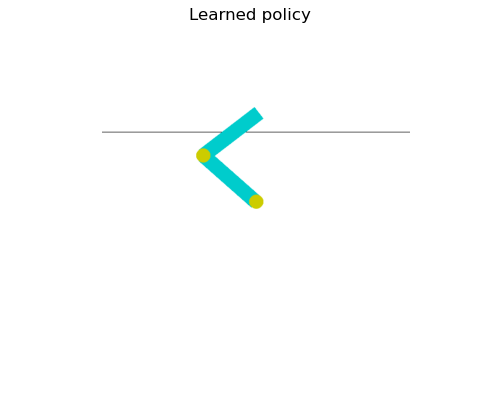

In [15]:
ani = agent.visualise()
ani;

#### End of chapter exercises:

1. How does varying `GAMMA` or `LR` affect performance?
2. What happens if vary the value of `UPDATE_EVERY`?
3. What changes do you need to make to the code to have the agent learn instead from the [Cart Pole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) environment?

### Solutions: 

1.

Gamma: 0.9; learning rate: 1e-06
Gamma: 0.9; learning rate: 1e-05
Gamma: 0.9; learning rate: 0.0001
Gamma: 0.9; learning rate: 0.001
Gamma: 0.9; learning rate: 0.01
Gamma: 0.925; learning rate: 1e-06
Gamma: 0.925; learning rate: 1e-05
Gamma: 0.925; learning rate: 0.0001
Gamma: 0.925; learning rate: 0.001
Gamma: 0.925; learning rate: 0.01
Gamma: 0.95; learning rate: 1e-06
Gamma: 0.95; learning rate: 1e-05
Gamma: 0.95; learning rate: 0.0001
Gamma: 0.95; learning rate: 0.001
Gamma: 0.95; learning rate: 0.01
Gamma: 0.975; learning rate: 1e-06
Gamma: 0.975; learning rate: 1e-05
Gamma: 0.975; learning rate: 0.0001
Gamma: 0.975; learning rate: 0.001
Gamma: 0.975; learning rate: 0.01
Gamma: 1.0; learning rate: 1e-06
Gamma: 1.0; learning rate: 1e-05
Gamma: 1.0; learning rate: 0.0001
Gamma: 1.0; learning rate: 0.001
Gamma: 1.0; learning rate: 0.01


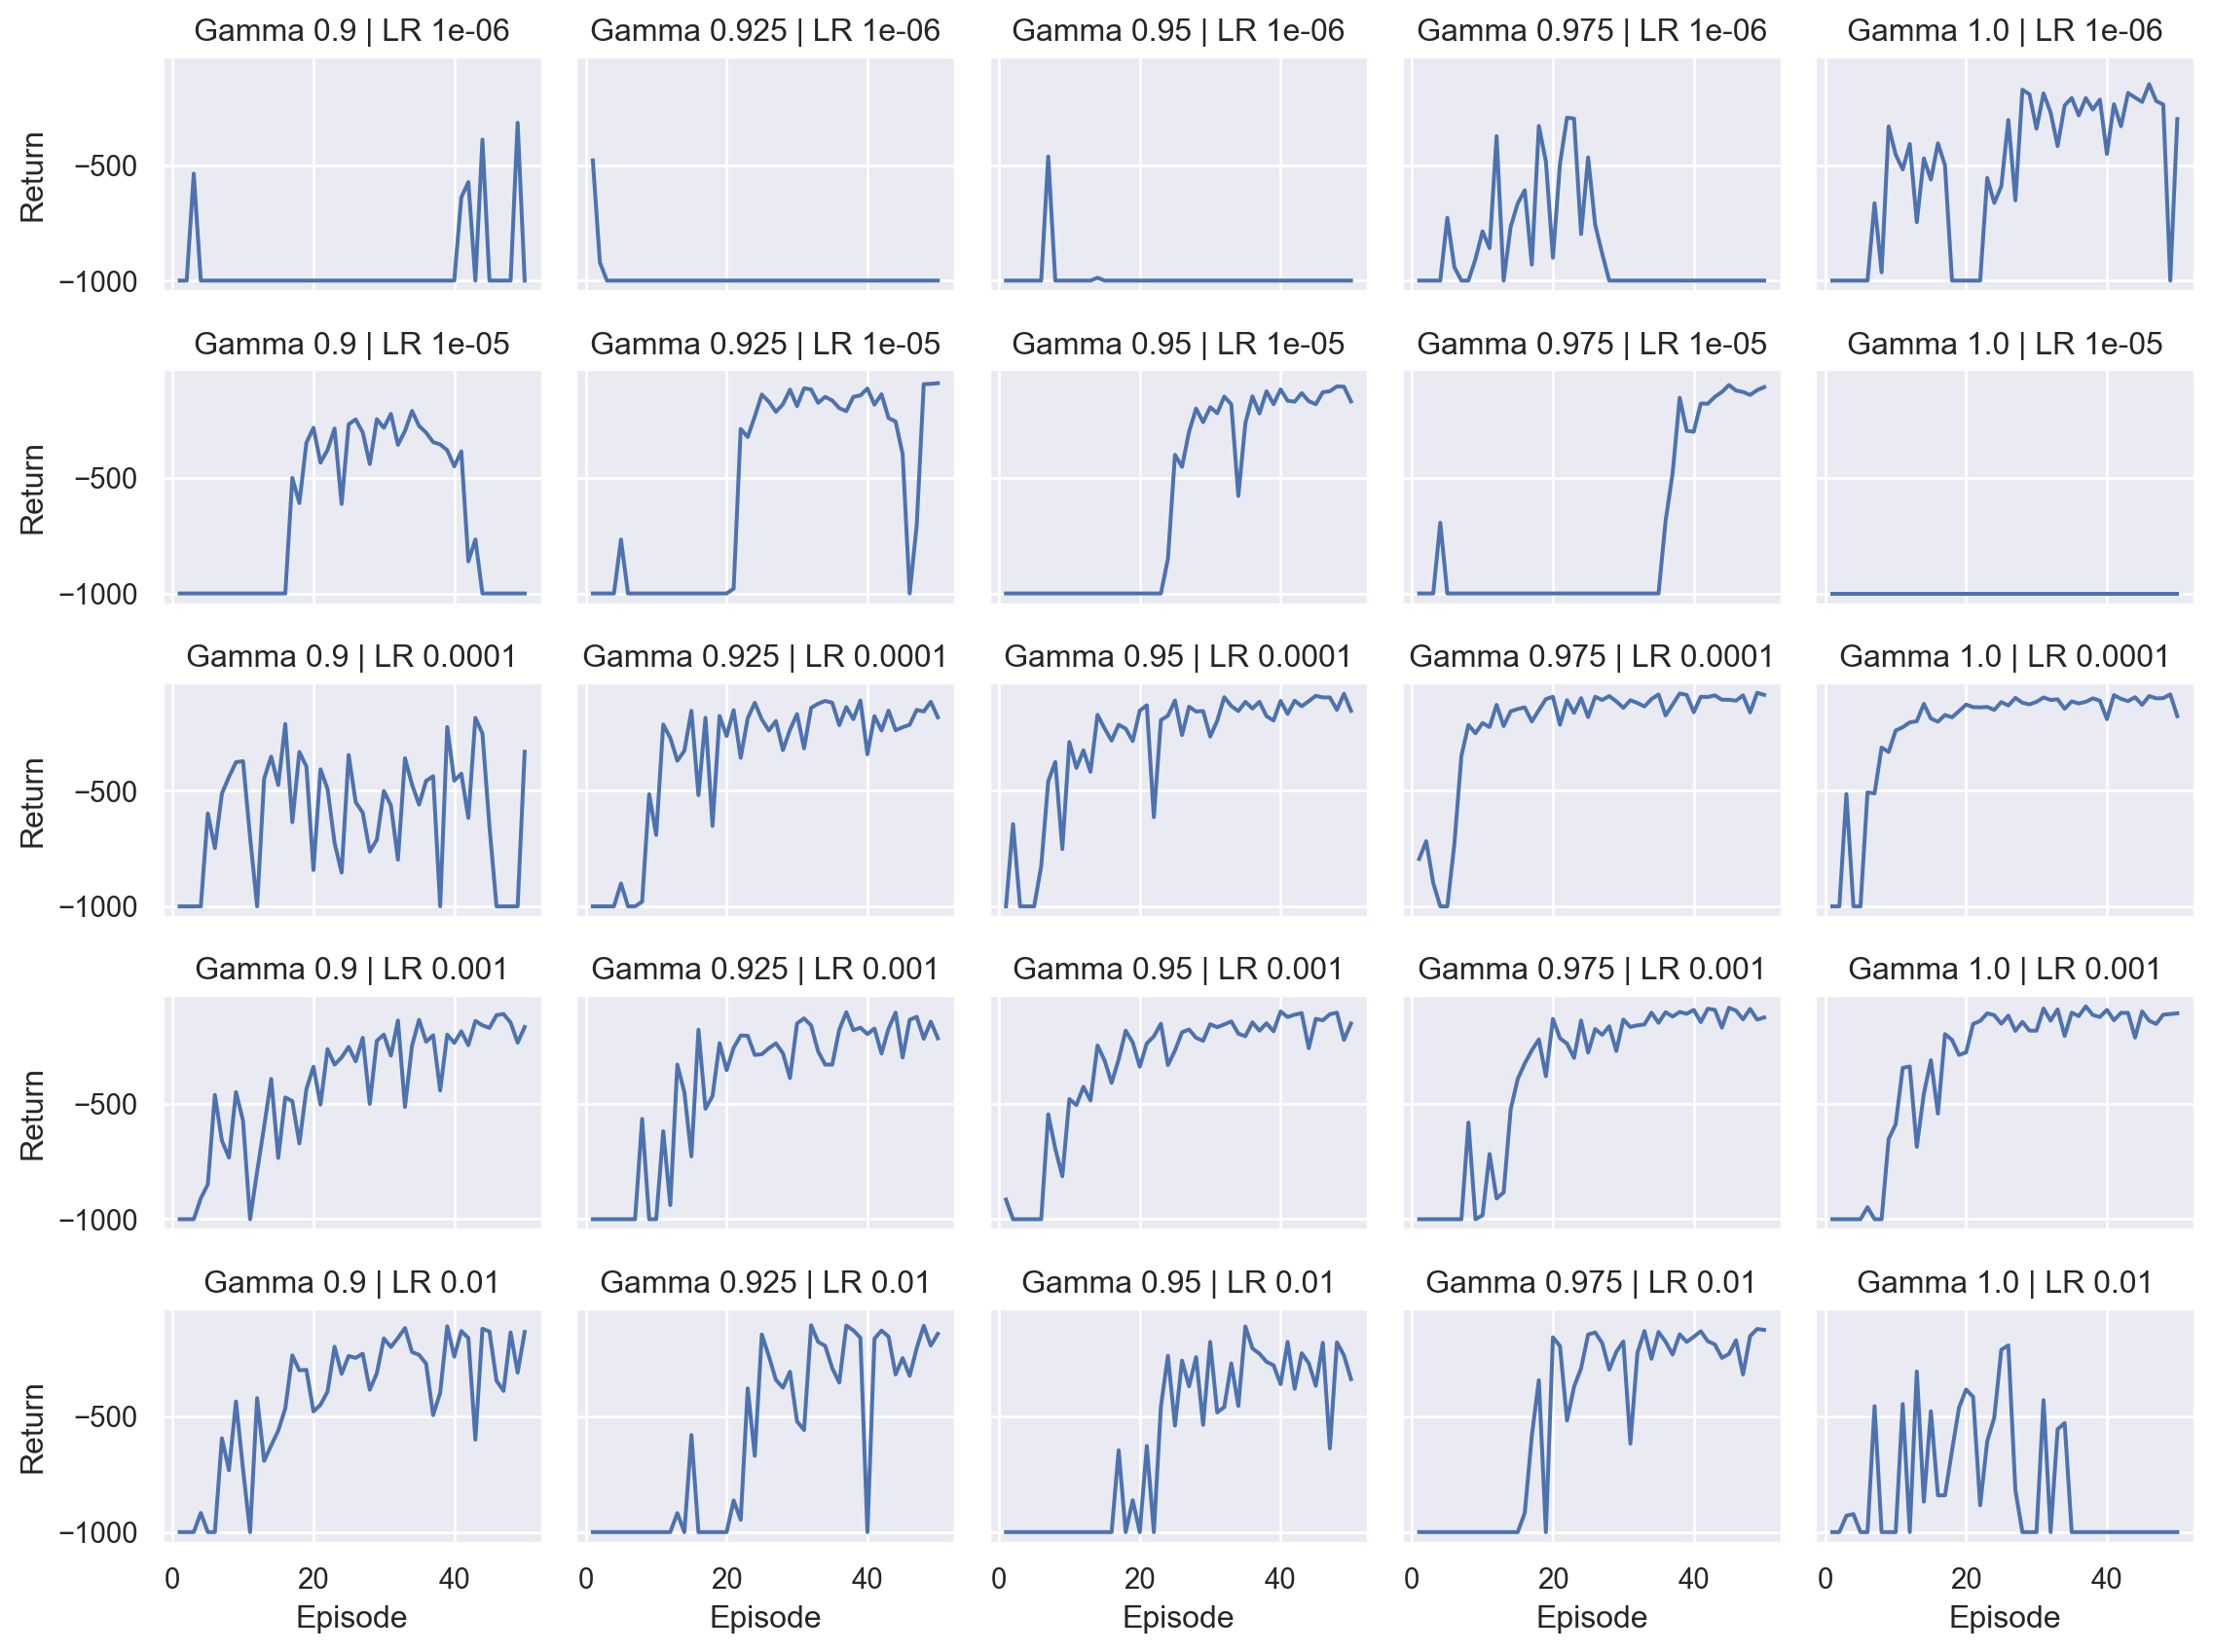

In [16]:
dfs = []
n_episodes = 50
for GAMMA in np.linspace(0.9, 1.0, 5):
    for LR in np.logspace(-6, -2, 5):
        print(f'Gamma: {GAMMA}; learning rate: {LR}')
        agent = DQN_agent(env, state_size=6, action_size=3)
        returns = agent.train(n_episodes=n_episodes, verbose=False)
        dfs.append(pd.DataFrame({
            'Gamma': GAMMA,
            'LR': LR,
            'Episode': range(1, n_episodes+1),
            'Return': returns
        }))
df = pd.concat(dfs).reset_index()
(
    so.Plot(df, 'Episode', 'Return')
    .facet('Gamma', 'LR')
    .add(so.Lines())
    .layout(size=(12, 9))
    .label(col="{}".format, row="{}".format)
)

The parameter values that we initially used for training were `GAMMA = 0.99` and `LR = 5e-4`, and these choices do seem to be vindicated by the chart above, although various other options would also have been fine. However if the learning rate is too low, e.g. 1e-6, the model never sees good returns, and if it's too high, e.g. 0.01, the results can also be poor.

2.

Update every: 2.0
Update every: 4.0
Update every: 8.0
Update every: 16.0
Update every: 32.0


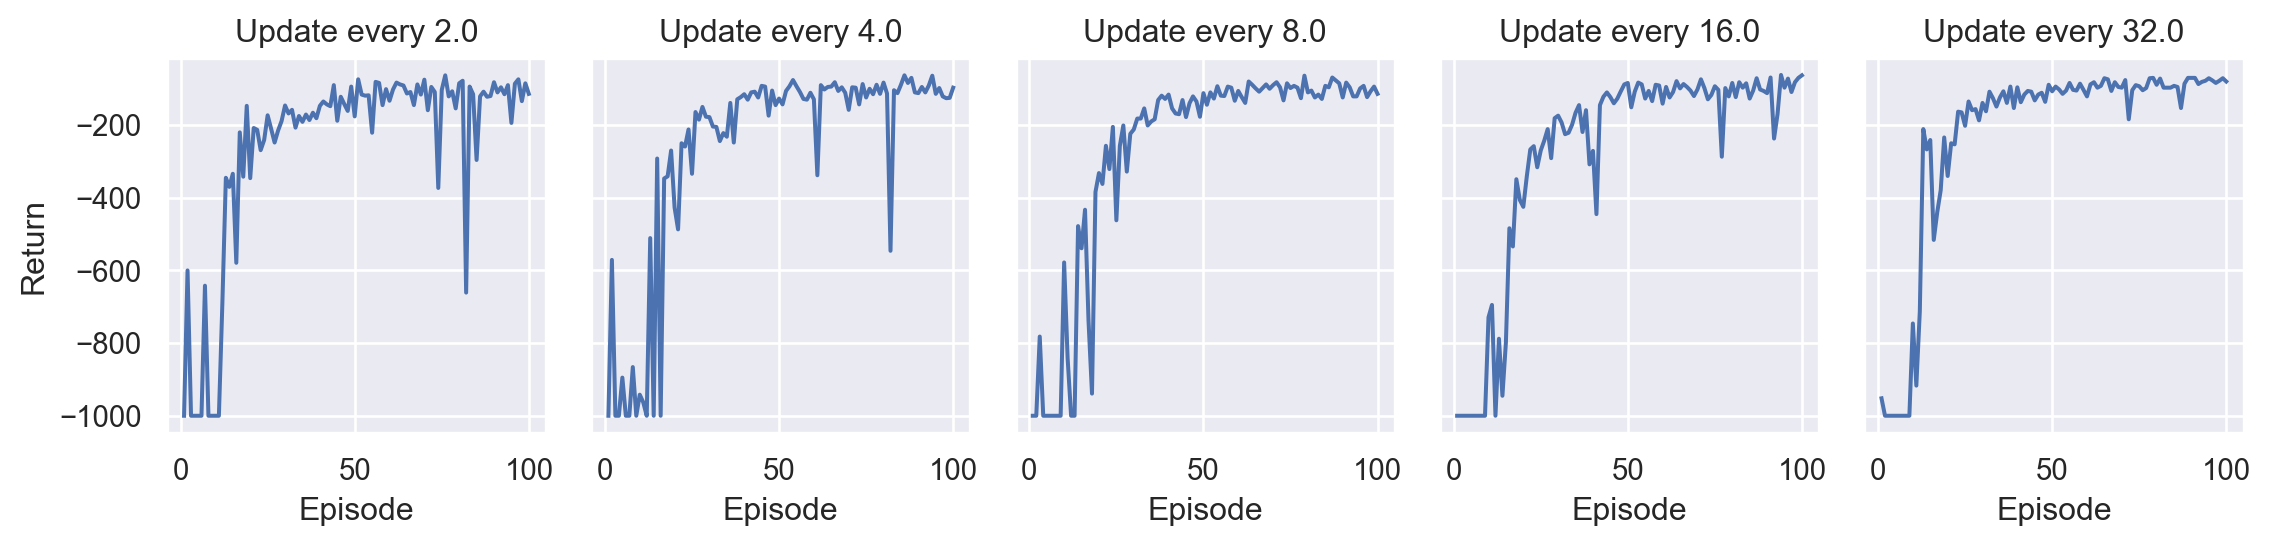

In [27]:
GAMMA = 0.99
LR = 5e-4

dfs = []
n_episodes = 100
for UPDATE_EVERY in np.logspace(1, 5, num=5, base=2):
    print(f'Update every: {UPDATE_EVERY}')
    agent = DQN_agent(env, state_size=6, action_size=3)
    returns = agent.train(n_episodes, verbose=False)
    dfs.append(pd.DataFrame({
        'Update every': UPDATE_EVERY,
        'Episode': range(1, n_episodes+1),
        'Return': returns
    }))
df = pd.concat(dfs).reset_index()
(
    so.Plot(df, 'Episode', 'Return')
    .facet('Update every')
    .add(so.Lines())
    .layout(size=(12, 3))
    .label(col="{}".format)
)

This chart also bolsters our initial choice of parameters of `UPDATE_EVERY = 8`. The model gets going more slowly with the higher values of this variable tested above, but nonetheless eventually achieves good performance. 

3. There are only a few changes we need to make to the code to get it learning from a different gymnasium environment. The documentation tells me that the action space for `Cart Pole` is of size two and the observation space has four variables, so the following tweaks should do the trick - we just need to reset the parameters that we were testing above first:

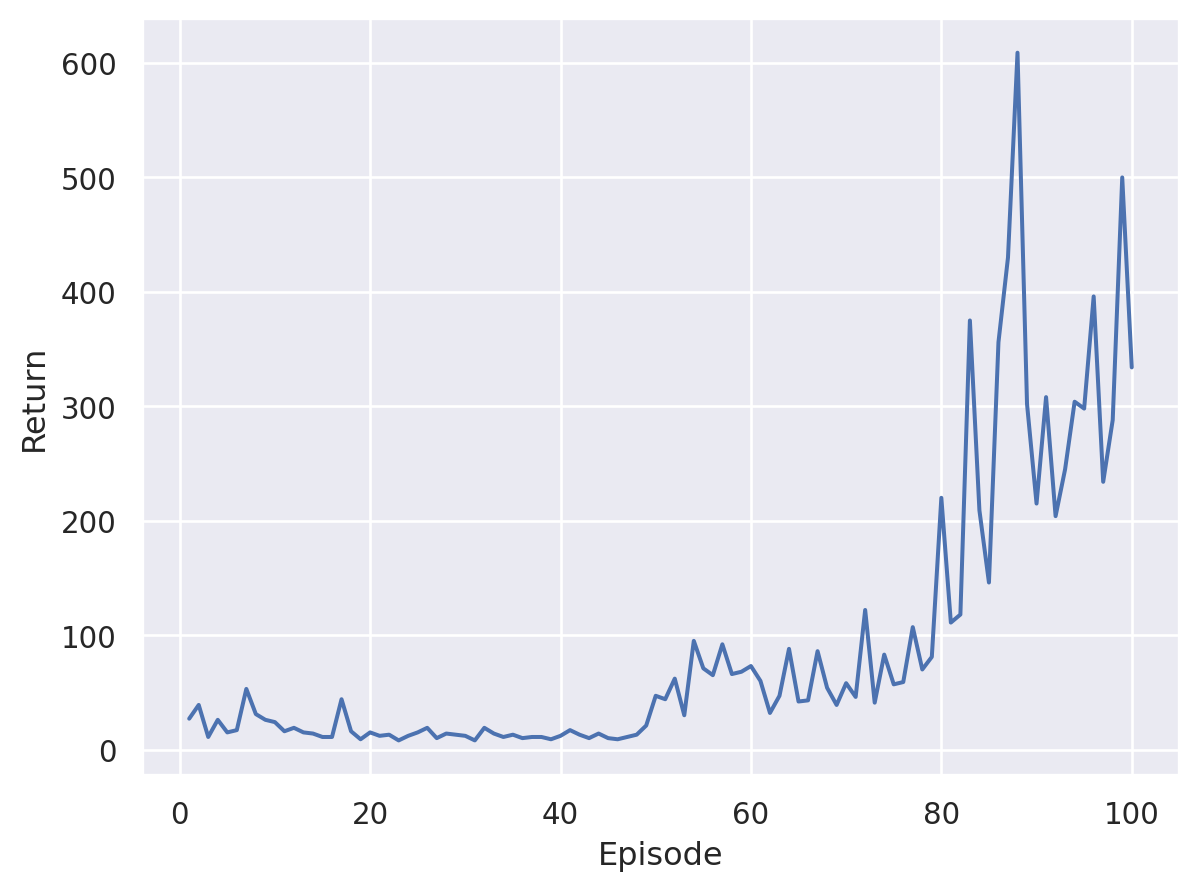

In [16]:
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate
UPDATE_EVERY = 8        # how often to update the network

cart_pole_env = gym.make('CartPole-v1', render_mode='rgb_array')
agent = DQN_agent(cart_pole_env, state_size=4, action_size=2)
returns = agent.train(n_episodes=100, verbose=False)
(
    so.Plot(
        data=pd.DataFrame({'Return': returns, 'Episode': range(1, len(returns)+1)}),
        x='Episode',
        y='Return'
    )
    .add(so.Line())
)

Feel free to tweak the parameter values - and even the architecture of the network - to see if you can get the cart balancing the pole for longer!

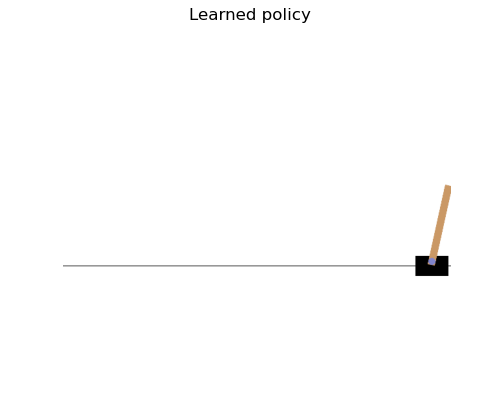

In [17]:
ani = agent.visualise()
ani;

### Key points

- Neural networks can be used as universal function approximators, and are therefore able to help a computer agent learn from a complex environment involving continuous variables in the observation space
- The way that a DQN agent learns is sensitive to the configuration of some key parameters, such as the learning rate and discount factor
- Network architecture that performs well in one problem space may also be applicable to others, with minimal changes